## TODO:
- Alles wat we voor liver/liver cancer nog moeten, moeten we hier ook aanpassen.
- Trainen voor spleen
- Patch size aanpassen naar de grootte van een spleen (ongeveer 125 x 75 x 50 mm)

## Segmentation of the spleen

In [2]:
# imports
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import json
import warnings
from random import randint
import random
import SimpleITK as sitk
from multi_slice_viewer import multi_slice_viewer
from IPython.display import clear_output
import pickle 
from tqdm import tqdm_notebook as tqdm
import warnings
import h5py
import ipywidgets
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, UpSampling3D, concatenate, Cropping3D, Reshape, BatchNormalization
import keras.callbacks
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from tensorflow.python.client import device_lib
from keras.utils import multi_gpu_model

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
assert len(K.tensorflow_backend._get_available_gpus()) > 0

In [3]:
# Task09_spleen dir in same directory as notebook
data_path = './Task09_Spleen/'

In [4]:
# info about dataset in json file
with open(data_path + 'dataset.json') as f:
    d = json.load(f)   
    
    # paths to training set images with label
    train_paths = d['training']
    
    # paths to testset images with label
    test_paths = d['test'] 

In [5]:
# change to data dir 
os.chdir(data_path)
print(os.getcwd())

/nfs/home3/hesterh/ISMI_project/Task09_Spleen


# Load the train set and test set as SITK images

In [16]:
# paths to files
train_imgs = [train_instance['image'] for train_instance in train_paths]
train_lbls = [train_instance['label'] for train_instance in train_paths]
test_imgs  = [test_instance for test_instance in test_paths]

## Resampling
Images do not have the same spacings. We will first resample. For this we need the spacings in the SITK images. Note that when converting sitk to numpy the z axis is placed at the front. Spacings in order: (x, y, z), numpy image: (z, x, y)

Resample to 1mm x 1mm x 1mm resolution => images should have different sizes (not all 512 x 512 x N anymore). 
For example, when the image has a shape of (512, 512, 74) and a spacing of (0.75, 0.75, 2),
you can calculate how wide the image is along the x-axis: 512 * 0.75 mm = 384 mm. As a tip, look for “scipy zoom”.

In [14]:
# now load one image and label at a time
def resample_and_save(paths, order, filename):     
    print('Storing resampled dataset at {}.'.format(os.path.join(os.getcwd(), filename)))    
    
    # make a h5py file to store images as numpy in
    with h5py.File(filename, 'w') as f: 
        for i, path in enumerate(tqdm(paths)):            
            
            # read the image
            img = sitk.ReadImage(path)
            
            # get the spacing
            spacing = img.GetSpacing()
            
            # change order
            x, y, z = spacing            
            spacing = (z, x, y)      # order: (z, x, y)

            # convert to numpy
            np_img = sitk.GetArrayFromImage(img)

            # apply zoom
            np_img_re = zoom(np_img, spacing, order=order)

            # save the resamples img/label
            dataset = f.create_dataset(str(i), data=np_img_re)      

In [22]:
# use order 3 interpolation for imgs, order 0 for labels
#resample_and_save(train_imgs, order=3, filename='spleen_resampled_train_imgs.h5py')
#resample_and_save(train_lbls, order=0, filename='spleen_resampled_train_lbls.h5py')
#resample_and_save(test_imgs, order=3, filename='spleen_resampled_test_imgs.h5py')

Storing resampled dataset at /nfs/home3/hesterh/ISMI_project/Task09_Spleen/spleen_resampled_train_imgs.h5py.


## Start here if you saved the resampled images and labels

In [4]:
# change to data dir
data_path = './Task09_Spleen/'
os.chdir(data_path)
print(os.getcwd())

/nfs/home3/hesterh/ISMI_project/Task09_Spleen


In [5]:
# load from disk
np_train_imgs = []
np_train_lbls = []

with h5py.File('spleen_resampled_train_imgs.h5py', 'r') as f: 
    for img in tqdm(f):
        dset = f[img]
        np_train_imgs.append(dset[:])
    
with h5py.File('spleen_resampled_train_lbls.h5py', 'r') as f: 
    for lbl in tqdm(f):
        dset = f[lbl]     
        np_train_lbls.append(dset[:])

## Do we have imbalances in our spleen data? 
This might be useful for later if we need class weights.

In [11]:
# count the labels of train images
sums = np.zeros(2)
for lbs in tqdm(np_train_lbls):
    labels, counts = np.unique(lbs, return_counts=True)
    sums += counts

In [12]:
# print percentages of voxels.
total = sum(sums)
print("{:.2f}% background, {:.2f}% spleen.".format(sums[0]/total*100, sums[1]/total*100))

99.60% background, 0.40% spleen.


In [13]:
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None: 
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial', overlay_1=self.lbls[i], overlay_1_thres=1, 
                   overlay_2=self.lbls[i], overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)
        else:
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial')  

# Split for training and validation

In [14]:
# split into training set and validation set
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)
n_validation_imgs = int(validation_percent * len(np_train_imgs))

val_set   = DataSet(np_train_imgs[:n_validation_imgs], np_train_lbls[:n_validation_imgs])
train_set = DataSet(np_train_imgs[n_validation_imgs:], np_train_lbls[n_validation_imgs:])

print('{} images in val set'.format(val_set.get_lenght()))
print('{} images in train set'.format(train_set.get_lenght()))

8 images in val set
33 images in train set


# Patch extractor
We re-use the patch extractor from assignment 7, but modify it to get 3D patches from a 3D image.
We can add augmentations later in the patch extractor. Note the extra dimension in the shape of patch_out and target_out. 

In [20]:
class PatchExtractor:

    def __init__(self, patch_size, fromSpleen):
        self.patch_size = patch_size 
        self.fromSpleen = fromSpleen
    
    def get_patch(self, image, label):
        ''' 
        Get a 3D patch of patch_size from 3D input image, along with corresponding 3D label map.
        Pick random location of the patch inside the image. The point is at the center of the patch.
        We first pad the image to not go out of bounds when extracting the patch.
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''
        
        # size of patch in each dimension
        pz, px, py = self.patch_size
        
#         print('Patch_size: {}'.format(patch_size))
#         print('Image_size: {}'.format(image.shape))

        # pad with the min value in the image
        min_val = np.min(image)
        
        # pad with half the patch size, I assume even patch size
        padded_img = np.pad(image, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant', constant_values=min_val)
        padded_lbl = np.pad(label, ((pz//2, pz//2), (px//2, px//2), (py//2, py//2)), 'constant')
        
#         print('Padded_size: {}'.format(padded_img.shape))

        # random between [0., 1.), if fromSpleen is true takes 70% of patches from spleen
        p = random.random()

        # centre of the patch: a random point from the spleen in the non padded image
        if self.fromSpleen and p > 0.3:
            
            # getting the spleen labeled points
            spleen_ind = np.argwhere(label == 1)  
            
            # get a random point from the liver labeled points
            r = randint(0, len(spleen_ind))
            z = spleen_ind[r][0]
            x = spleen_ind[r][1]
            y = spleen_ind[r][2]
            
        # centre of the patch: a random location in the non padded image    
        else:
            dims = image.shape
            z = randint(0, dims[0]) 
            x = randint(0, dims[1]) 
            y = randint(0, dims[2])   
            
        # z, x, y is the left bottom corner of the patch in the padded image (index shift with pad size)     
        # take a patch, with the random point at the center in the padded img
        patch  = padded_img[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)
        target = padded_lbl[z:z+pz, x:x+px, y:y+py].reshape(pz, px, py, 1)

        return patch, target

(156, 156, 156, 1)
(156, 156, 156, 1)


<IPython.core.display.Javascript object>


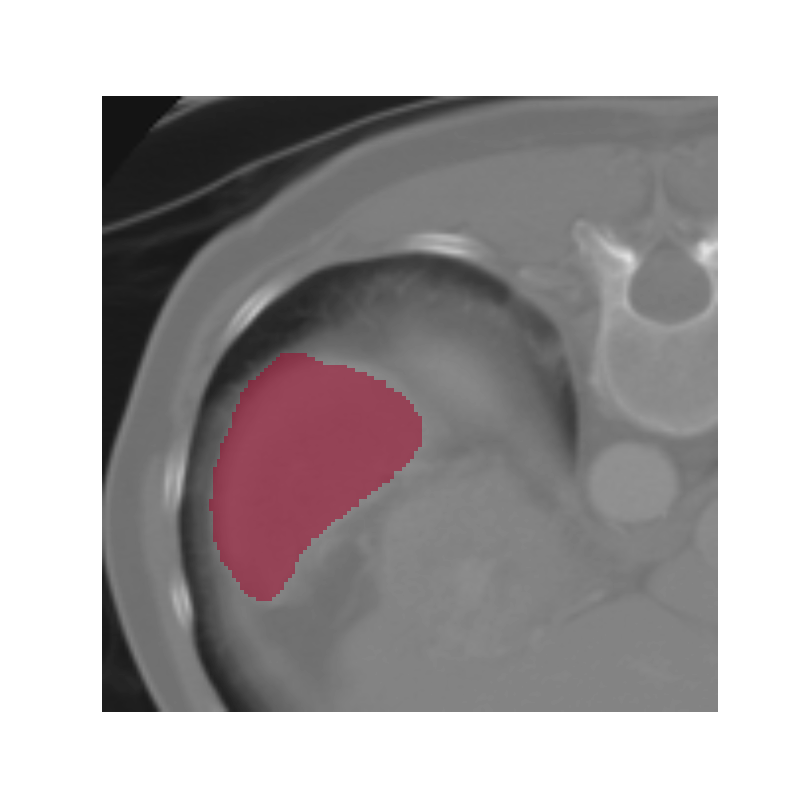

In [21]:
# get an image and a label from our train set
image = train_set.imgs[0]
label = train_set.lbls[0]

# test PatchExtractor
patch_size = (156, 156, 156)
patch_extractor = PatchExtractor(patch_size=patch_size, fromSpleen=True)

# lets check some patches
patch, target = patch_extractor.get_patch(image, label)

print(patch.shape)
print(target.shape)

# show patch
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(patch.reshape(patch_size), view='axial', overlay_1=target.reshape(patch_size), overlay_1_thres=1, 
                   overlay_2=target.reshape(patch_size), overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Batch creator
Lets also reuse the batch creator from assignment 7. We are going to use valid convolutions, which means the output of our network will be smaller than the input. The purpose of this batchcreator is the make batches consisting of patches with their corresponding labels (for the network to train on). Since a UNet with valid convolutions has a smaller output than input, we need to crop the label based on the target size aswell. And labels should be in onehot.

In [22]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used        
        self.imgs = dataset.imgs
        self.lbls = dataset.lbls                
        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single (batch of?) patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 1))  # 1 channel
        y_data = np.zeros((batch_size, *self.target_size, 2)) # one-hot encoding with 2 classes
        
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs))                   # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]       # get image and segmentation map
            
            # clip values outside [-1000, 3000] and normalize image intensity to range [0., 1.]      
            img = np.clip(img, -1000, 3000)
            img = (img - np.min(img)) / np.ptp(img)     
            
            # get a patch with corresponding labels from the patch extractor
            patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl)   
            
            # crop labels based on target_size           
            ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2    
            pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            pd = (self.patch_extractor.patch_size[2] - self.target_size[2]) // 2
            
            # take the cropped patch, it contains labels with values 0,1,2
            cropped_patch = patch_lbl[ph:ph+self.target_size[0], pw:pw+self.target_size[1], pd:pd+self.target_size[2]].squeeze()
            
            # instead of 0,1,2 label values we want categorical/onehot => 0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]
            onehot = to_categorical(cropped_patch, num_classes=2)
            
            x_data[i, :, :, :, :] = patch_img
            y_data[i, :, :, :, :] = onehot
        
        return (x_data.astype(np.float32), y_data.astype(np.float32))
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

# 3D UNet Model
Start with this model, we can adapt this later if needed. Build like the net from: 
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.

In [23]:
# make block of two convolve3D's
def unet_block(inputs, n_filters, padding, up_conv=False, batchnorm=False):
    # 3d convolve, 32 3x3x3 filters 
    c1 = Conv3D(n_filters, (3,3,3), activation='relu', padding=padding)(inputs)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    
    # up conv (normal conv in the expanding path) has same number of filters twice
    if up_conv:
        c2 = Conv3D(n_filters, (3, 3, 3), activation='relu', padding=padding)(c1)
    else:          # normal convs have twice the filters in the second conv
        c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', padding=padding)(c1)
        
    if batchnorm:
        c2 = BatchNormalization()(c2)
    
    return c2

In [24]:
# 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.
def build_unet_3d(initial_filters, padding, batchnorm=True, print_model=False):
    
    ## CONTRACTING PATH
    
    # (spac_dim_1, space_dim_2, space_dim_3, channels)
    inputs = Input(shape=(156, 156, 156, 1))

    # First conv pool, 32 filters and 64 filters    
    block_1    = unet_block(inputs, initial_filters, padding=padding, batchnorm=batchnorm) 
    max_pool_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_1)  # 2×2×2 max pooling with strides two
                                                                        # needs even spacial_dimensions as input
    # second conv pool, 64 filters, 128 filters    
    block_2    = unet_block(max_pool_1, initial_filters*2, padding=padding, batchnorm=batchnorm)
    max_pool_2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_2)
    
    # third conv pool, 128 filters, 256 filters    
    block_3    = unet_block(max_pool_2, initial_filters*4, padding=padding, batchnorm=batchnorm)
    max_pool_3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_3)
    
    # just a conv block without maxpooling, 256 filters and 512 filters
    conv_4     = unet_block(max_pool_3, initial_filters*8, padding=padding, batchnorm=batchnorm)
    
    ## EXPANDING PATH   
        
    # round 1
    up_conv_3  = Conv3DTranspose(16*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(conv_4)
    crop_3     = Cropping3D(cropping=4)(block_3) 
    concat_3   = concatenate([crop_3, up_conv_3])  
    up_block_3 = unet_block(concat_3, 8*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 2
    up_conv_2  = Conv3DTranspose(8*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_3) 
    crop_2     = Cropping3D(cropping=16)(block_2) 
    concat_2   = concatenate([crop_2, up_conv_2])  
    up_block_2 = unet_block(concat_2, 4*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 3
    up_conv_1  = Conv3DTranspose(4*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_2) 
    crop_1     = Cropping3D(cropping=40)(block_1) 
    concat_1   = concatenate([crop_1, up_conv_1])  
    up_block_1 = unet_block(concat_1, 2*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # finish with 1x1x1 conv, 3 filters, # labels, softmax or ReLU?
    finish = Conv3D(2, (1,1,1), activation='softmax', padding=padding)(up_block_1)
    
    model = Model(inputs, finish) 
    
    if print_model:
        print(model.summary(line_length=150))
    
    return model

In [25]:
unet_3d = build_unet_3d(initial_filters=32, padding='valid', batchnorm=False, print_model=True)

Instructions for updating:
Colocations handled automatically by placer.
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             (None, 156, 156, 156, 1)         0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 154, 154, 154, 32)        896               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_2 (Conv3D)     

## Testing the batch generator

(batch, d, h, w, channels)
xdata has shape: (2, 156, 156, 156, 1)
ydata has shape: (2, 68, 68, 68, 2)
Occuring values in true labels: [ 0.  1.]
Min of input: 0.0
Max of input: 0.8762127161026001


<IPython.core.display.Javascript object>


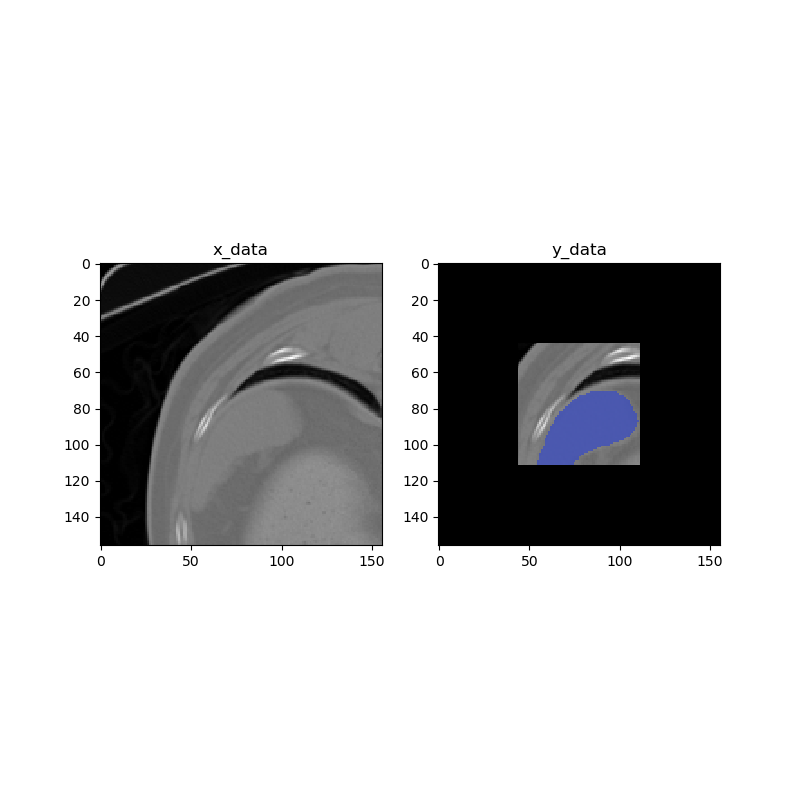

In [27]:
# define parameters for the batch creator
patch_size  = (156, 156, 156)  # isotropic patch size
target_size = (68, 68, 68)     # output size, smaller since valid convolutions are used
batch_size  = 2                # number of patches in a mini-batch, for segmentation 1 is fine, since the 
                               # output of the net is many thousands of values per patch, which all contribute to the loss

# initialize patch generator and batch creator
patch_generator       = PatchExtractor(patch_size, fromSpleen=True)
batch_generator_train = BatchCreator(patch_generator, train_set, target_size=target_size)
batch_generator_val   = BatchCreator(patch_generator, val_set, target_size=target_size)

# get one minibatch
x_data, y_data = batch_generator_train.create_image_batch(batch_size)

print("(batch, d, h, w, channels)")
print('xdata has shape: {}'.format(x_data.shape))
print('ydata has shape: {}'.format(y_data.shape))
print('Occuring values in true labels: {}'.format(np.unique(y_data)))
print('Min of input: {}'.format(np.min(x_data)))
print('Max of input: {}'.format(np.max(x_data)))

# show the patches, to check the batchcreator, mid slice
x = patch_size[0] // 2
patch = x_data[0, x, :, :].squeeze()

# get labels from one hot
label = np.argmax(y_data[0, :, :, :], axis=-1)

# labels were cropped, so pad them
p = (patch_size[0] - target_size[0]) // 2
padded_lbl = np.pad(label, ((p, p), (p, p), (p, p)), 'constant', constant_values=3.)

# makes masks to plot label overlay
masked_crop = np.ma.masked_where(padded_lbl != 3, padded_lbl)
masked_lbl  = np.ma.masked_where(padded_lbl == 0, padded_lbl)

# take the mid slice aswell
masked_lbl  = masked_lbl[x, :, :]            
masked_crop = masked_crop[x, :, :]

# show x_data (no labels) and y_data, which are the labels for the center crop of x_data
# y_data is plotted with padding to check
plt.figure()
plt.subplot(1, 2, 1, title='x_data')
plt.imshow(patch, cmap='gray')
plt.subplot(1, 2, 2, title='y_data')
plt.imshow(patch, cmap='gray')
plt.imshow(masked_lbl, cmap='coolwarm', alpha = 0.75)
plt.imshow(masked_crop, cmap='gray', alpha = 1)
plt.show()

## Define a logger which saves the losses and saves the best model

In [28]:
class Logger(keras.callbacks.Callback):

    # logg losses, removed accs for now
    def __init__(self, data_dir, model_name, base_model):  
        self.model_filename = os.path.join(data_dir, model_name + '_spleen.h5')        
        self.tr_losses = []  
        self.val_losses = []      
        self.best_val_loss = float("inf")   
        self.base_model = base_model
       
    def on_epoch_end(self, batch, logs={}):
        # add validation info
        self.val_losses.append(logs.get('val_loss'))
        self.tr_losses.append(logs.get('loss'))
        self.plot()

        # safe best model after epoch end
        if self.val_losses[-1] < self.best_val_loss:
            self.best_val_loss = self.val_losses[-1]
            
            # call save on the base model instead of the parallel model, both models share the same weights
            self.base_model.save(self.model_filename) # save best model to disk
            print('Best model saved as {}'.format(self.model_filename))
         
    def plot(self): 
        clear_output()
        plt.figure(figsize=(8, 4))
        n = len(self.val_losses) + 1         
        plt.plot(range(1, n), self.tr_losses, label='train loss')         
        plt.plot(range(1, n), self.val_losses, label='val loss')        
        plt.legend(loc='lower left')
        plt.show()

In [29]:
# make a data dir to store best model
print(os.getcwd())
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

/nfs/home3/hesterh/ISMI_project/Task09_Spleen


## Dice Loss (hier moeten we nog naar kijken!!!)
Dice loss seems to be a good pick for 3D segmentation with class inbalances. (see https://arxiv.org/pdf/1707.03237.pdf)

**For binary volumes of N voxels (Milletari et al., 2016, VNet): http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf**

$$ \textbf{DL}_1 = 1 -\frac{2 \sum_{i}^{N} p_{i} g_{i}}{\sum_{i}^{N} p_{i}^{2}+\sum_{i}^{N} g_{i}^{2}} $$

## Now we define parameters, compile the model and train the network 

In [31]:
# build model
unet_3d = build_unet_3d(initial_filters=32, padding='valid', batchnorm=False, print_model=False)

# parameters
learning_rate   = 3*10**-4
optimizer       = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
steps_per_epoch = 50
epochs          = 10
batch_size      = 2
logger          = Logger(data_dir, 'test-02-06v2', base_model=unet_3d)

# get generators
image_generator_train = batch_generator_train.get_image_generator(batch_size)
image_generator_val   = batch_generator_val.get_image_generator(batch_size)

# compile model
parallel_model = multi_gpu_model(unet_3d, gpus=2)                   # batchsize should be a multiple of #gpu's
parallel_model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [33]:
# back to inline
%matplotlib inline

In [ ]:
# train the model
parallel_model.fit_generator(generator=image_generator_train, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=image_generator_val,                  
                    verbose=1,
                    validation_steps=25,
                    callbacks=[logger])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
22/50 [============>.................] - ETA: 5:15 - loss: 0.8120